In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 100% !important; }</style>"))

## Forecasting Stock Prices of Volkswagen
**Note :** Fourier Series will only work if you have features other than the output feature | only a single target value in the dataset cannot help with fourier transformation

In [63]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import yfinance

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 22, 7
import seaborn as sns
sns.set()

In [64]:
raw_data = yfinance.download(tickers= "VOW3.DE", interval= "1d",
                             group_by='ticker', auto_adjust=True, treads=True)
df= raw_data.copy()
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
1998-07-22,33.009003,34.005072,33.009003,33.766056,56336
1998-07-23,34.138089,34.403602,32.278446,32.278446,95571
1998-07-24,31.879916,32.543962,31.295368,32.145432,154423
1998-07-27,32.145429,32.411463,31.082852,31.215868,62875
1998-07-28,30.950353,32.118928,30.232789,30.471804,116194
...,...,...,...,...,...
2021-08-25,199.380005,202.250000,198.000000,199.699997,559333
2021-08-26,198.600006,201.449997,197.520004,200.000000,621505
2021-08-27,200.050003,200.800003,198.699997,200.750000,458406


## Defining Key Dates

In [65]:
## Starting Dates
start_date = "2009-04-05"

# First official Announcement - 49.9 %
ann_1 = "2009-12-09"

# Second Official Announcement - 50.1 %
ann_2 = '2012-07-05'

#Ending Date
end_date = "2014-01-01"

#Dieselgate Scandle
d_gate = "2015-09-20"

## Data Preporcessing

In [66]:
# Creating returns
#f['Return'] = df.Close.pct_change(1).mul(100)

# Creating Squared Returns 
#f['Return_sq'] = df.Return.mul(df.Return)

#Assigning the frequencies and filling na values 
df = df.asfreq('b')
df = df.fillna(method='ffill')

#Getting Day, Month and year
df['Day'] = df.index.day
df['Month'] = df.index.month
df['Year'] = df.index.year

In [67]:
df = df[['Close', 'Day', 'Month', 'Year']]
df

,Close,Day,Month,Year
Date,,,,
1998-07-22,33.766056,22,7,1998
1998-07-23,32.278446,23,7,1998
1998-07-24,32.145432,24,7,1998
1998-07-27,31.215868,27,7,1998
1998-07-28,30.471804,28,7,1998
...,...,...,...,...
2021-08-25,199.699997,25,8,2021
2021-08-26,200.000000,26,8,2021
2021-08-27,200.750000,27,8,2021


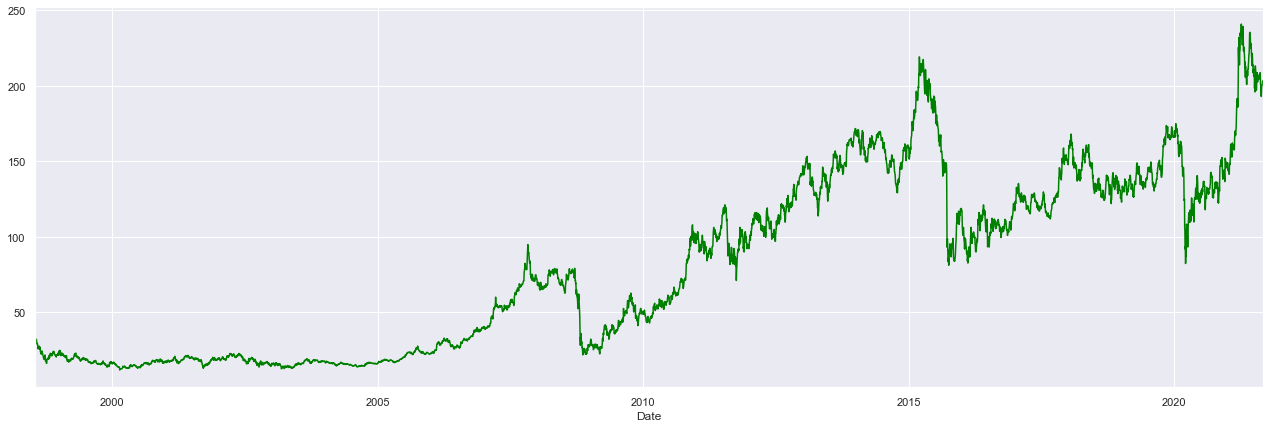

In [68]:
df.Close.plot(color='green');

In [69]:
'''
from sklearn.base import BaseEstimator, TransformerMixin

class IndexSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        """Return indices of a data frame for use in other estimators."""
        pass
    
    def fit(self, df, y=None):
        return self
    
    def transform(self, df):
        indices = df.index
        return indices.values.reshape(-1, 1)
'''

'\nfrom sklearn.base import BaseEstimator, TransformerMixin\n\nclass IndexSelector(BaseEstimator, TransformerMixin):\n    def __init__(self):\n        """Return indices of a data frame for use in other estimators."""\n        pass\n    \n    def fit(self, df, y=None):\n        return self\n    \n    def transform(self, df):\n        indices = df.index\n        return indices.values.reshape(-1, 1)\n'

In [70]:
'''
def ts_train_test_split(df, cutoff, target):
    """Perform a train/test split on a data frame based on a cutoff date."""
    
    ind = df.index < cutoff
    
    df_train = df.loc[ind]
    df_test = df.loc[~ind]
    y_train = df.loc[ind, target]
    y_test = df.loc[~ind, target]
    
    return df_train, df_test, y_train, y_test

def plot_results(df, y_pred):
    """Plot predicted results and residuals."""
    
    df.Close.plot();
    plt.plot(list(df.index), y_pred, '-r');
    plt.xlabel('year')
    plt.ylabel('CO2 ppm')
    plt.legend(['true', 'predicted']);
    plt.show();

    plt.plot(resd)
    plt.xlabel('year')
    plt.ylabel('residual')
'''

'\ndef ts_train_test_split(df, cutoff, target):\n    """Perform a train/test split on a data frame based on a cutoff date."""\n    \n    ind = df.index < cutoff\n    \n    df_train = df.loc[ind]\n    df_test = df.loc[~ind]\n    y_train = df.loc[ind, target]\n    y_test = df.loc[~ind, target]\n    \n    return df_train, df_test, y_train, y_test\n\ndef plot_results(df, y_pred):\n    """Plot predicted results and residuals."""\n    \n    df.Close.plot();\n    plt.plot(list(df.index), y_pred, \'-r\');\n    plt.xlabel(\'year\')\n    plt.ylabel(\'CO2 ppm\')\n    plt.legend([\'true\', \'predicted\']);\n    plt.show();\n\n    plt.plot(resd)\n    plt.xlabel(\'year\')\n    plt.ylabel(\'residual\')\n'

In [71]:
'''from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# perform train/test split
cutoff = '2019-01-01'
df_train, df_test, y_train, y_test = ts_train_test_split(df, cutoff, 'Close')

# construct and train pipeline
#time = IndexSelector()
poly = PolynomialFeatures(degree=2)
lr = LinearRegression()
pipe = Pipeline([('drift', poly),
                 ('regressor', lr)])
pipe.fit(df_train, y_train)

# make predictions
y_pred = pipe.predict(df)
resd = df.Close - y_pred
print("Test set R^2: {:g}".format(pipe.score(df_test, y_test)))
plot_results(df, y_pred)'''

'from sklearn.linear_model import LinearRegression\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.preprocessing import PolynomialFeatures\n\n# perform train/test split\ncutoff = \'2019-01-01\'\ndf_train, df_test, y_train, y_test = ts_train_test_split(df, cutoff, \'Close\')\n\n# construct and train pipeline\n#time = IndexSelector()\npoly = PolynomialFeatures(degree=2)\nlr = LinearRegression()\npipe = Pipeline([(\'drift\', poly),\n                 (\'regressor\', lr)])\npipe.fit(df_train, y_train)\n\n# make predictions\ny_pred = pipe.predict(df)\nresd = df.Close - y_pred\nprint("Test set R^2: {:g}".format(pipe.score(df_test, y_test)))\nplot_results(df, y_pred)'

In [72]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class FourierComponents(BaseEstimator, TransformerMixin):
    def __init__(self, freqs):
        """Create features based on sin(2*pi*f*t) and cos(2*pi*f*t)."""
        self.freqs = freqs
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xt = np.zeros((X.shape[0], 2*len(self.freqs)))
        
        for i, f in enumerate(self.freqs):

            Xt[:, 2*i]= np.cos(2*np.pi*f*X).reshape(-1)
            Xt[:, 2*i + 1] = np.sin(2*np.pi*f*X).reshape(-1)
    
        return Xt

In [73]:
fourier= FourierComponents([1/(365), 1/(2*365), 1/(260)])
pipe = Pipeline([
    ('fourier', fourier),
    ('lr', GridSearchCV(Ridge(), param_grid={'alpha': np.logspace(-2,2,10)}, cv=TimeSeriesSplit(5)))
])

In [87]:
fourier.fit_transform(df['Close'].values)

array([[ 0.83577375,  0.54907398,  0.95806413,  0.28655388,  0.68514484,
         0.72840685],
       [ 0.84955889,  0.52749378,  0.96165454,  0.27426366,  0.71088254,
         0.70331075],
       [ 0.85076449,  0.52554713,  0.9619679 ,  0.27316251,  0.71313962,
         0.70102203],
       ...,
       [-0.95105652, -0.30901699, -0.15643447,  0.98768834,  0.13850832,
        -0.99036127],
       [-0.94971784, -0.31310704, -0.15855939,  0.98734944,  0.14448905,
        -0.9895064 ],
       [-0.93688135, -0.34964746, -0.17764945,  0.98409383,  0.19805215,
        -0.98019149]])

In [79]:
pipe.fit(df['Close'].values, df['Close'])

Pipeline(steps=[('fourier',
                 FourierComponents(freqs=[0.0027397260273972603,
                                          0.0013698630136986301,
                                          0.0038461538461538464])),
                ('lr',
                 GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                              estimator=Ridge(),
                              param_grid={'alpha': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])}))])

In [81]:
pred = pd.DataFrame(pipe.predict(df['Close'].values), index = df.index, columns=['predictions'])
pred.head()

,predictions
Date,
1998-07-22,33.665019
1998-07-23,32.177680
1998-07-24,32.044761
1998-07-27,31.116208
1998-07-28,30.373404


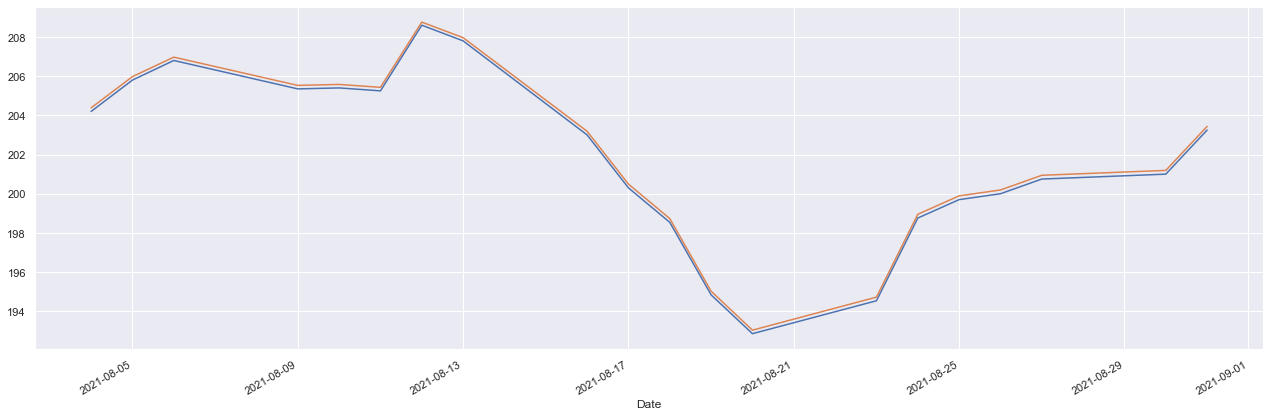

In [82]:
plt.plot(df['Close'][-20:])
pred.predictions[-20:].plot();

In [83]:
pipe.score(df['Close'].values, df['Close'])

0.999998594033919

In [84]:
df_test

,Close,Day,Month,Year
Date,,,,
2019-01-01,126.618492,1,1,2019
2019-01-02,124.194031,2,1,2019
2019-01-03,122.826851,3,1,2019
2019-01-04,128.040359,4,1,2019
2019-01-07,128.186188,7,1,2019
...,...,...,...,...
2021-08-25,199.699997,25,8,2021
2021-08-26,200.000000,26,8,2021
2021-08-27,200.750000,27,8,2021
